In [1]:
from bs4 import BeautifulSoup
import pandas as pd
from geopy.geocoders import GoogleV3
from shapely.geometry import Point
import geopandas as gpd
from random import randint
from time import sleep

In [2]:
%matplotlib inline

This import will fail unless you create a `credentials.py` file. See `credentials_template.py`

In [3]:
from credentials import GOOGLE_KEY

Read html copied from `http://www.in-n-out.com/locations`

In [4]:
with open("../data/innout/locator.html", "r") as f:
    html = f.read()

Parse html and grab a list of results

In [5]:
soup = BeautifulSoup(html)
results = soup.find_all("div", class_ = "result")

Loop results and grab data

In [6]:
stores = []

for each in results:
    store_number = each['data-storenumber']
    address = each.find('h3').text
    p = each.find('h3').next_sibling.find_all("span")
    city = p[0].text
    state = p[1].text
    
    stores.append({
        "store_number": store_number,
        "city": city,
        "state": state,
        "address": address,
        "latitude": "na",
        "longitude": "na"
    })
    

Set up the Google API

In [7]:
locator = GoogleV3(api_key=GOOGLE_KEY, timeout = 10)

Geocode

In [8]:
for each in stores:
    location = locator.geocode(f"{each['address']}, {each['city']}, {each['state']}, USA")
    
    each['latitude'] = location.latitude
    each['longitude'] = location.longitude

Create a dataframe

In [9]:
df = pd.DataFrame(stores)
df.head(3)

,address,city,latitude,longitude,state,store_number
0,555 Willie Stargell Ave.,Alameda,37.783793,-122.277219,CA,303
1,1210 N. Atlantic Blvd.,Alhambra,34.105994,-118.134390,CA,121
2,190 E. Stacy Rd.,Allen,33.126701,-96.659140,TX,255


Create a `coordinates` column

In [10]:
df['coordinates'] = list(zip(
    pd.to_numeric(df.longitude), 
    pd.to_numeric(df.latitude)
))
                         
# use shapely to transform tuples to `Points`
df['coordinates'] = df['coordinates'].apply(Point)

In [11]:
df.head()

,address,city,latitude,longitude,state,store_number,coordinates
0,555 Willie Stargell Ave.,Alameda,37.783793,-122.277219,CA,303,POINT (-122.2772186 37.7837934)
1,1210 N. Atlantic Blvd.,Alhambra,34.105994,-118.134390,CA,121,POINT (-118.1343897 34.1059937)
2,190 E. Stacy Rd.,Allen,33.126701,-96.659140,TX,255,POINT (-96.65913979999999 33.1267011)
3,601 W. Main St.,American Fork,40.386869,-111.858506,UT,239,POINT (-111.8585055 40.386869)
4,1168 State College Blvd.,Anaheim,33.819029,-117.888938,CA,300,POINT (-117.8889384 33.8190293)


In [12]:
# convert to GeoDataFrame
gdf = gpd.GeoDataFrame(
    df, 
    geometry = 'coordinates'
)

# http://spatialreference.org/ref/epsg/4326/
gdf.crs = {'init':'epsg:4326'}

Check to see if it works

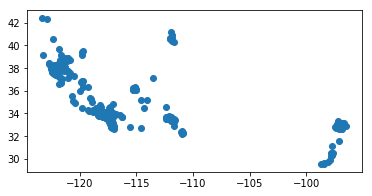

In [13]:
gdf.plot()

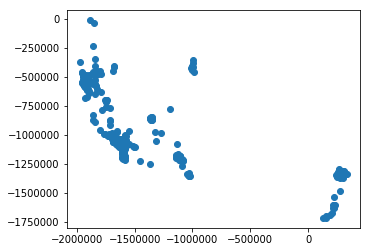

In [14]:
gdf.to_crs({"init": "epsg:2163"}).plot()

Write to file

In [15]:
gdf.to_crs(
    {"init": "epsg:2163"}
).to_file(
    "../output/innout/innout.shp"
)

/Users/scottpham/.local/share/virtualenvs/geopandas-sVWd-EJh/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
